### Title: Mutation dependent synthetic lethyal pipeline -- tumor type comparison
<font color='blue'> Author:</font>  Guangrong Qin<br/>

<font color='blue'> Contact:</font>  gqin@systemsbiology.org<br/>

<font color='blue'> Description:</font> This notebook is used to answer which gene knockout or gene knockdown  show sensitivity to certain gene mutation or the mutation of a group of genes in different tumor types <br/>

<font color='blue'>Citations:</font> The functional screening data and omics data for cell lines is from the Depmap and CCLE project from the Broad institute (DepMap Public 20Q3). To use this jupyter notebook and the data which are used in the jupyter notebook, Please cite the following papers<br/>

Bahar Tercan, Guangrong Qin, Taek-Kyun Kim, Boris Aguilar, Christopher J. Kemp, Nyasha Chambwe, Ilya Shmulevich. SL-Cloud: A Computational Resource to Support Synthetic Lethal Interaction Discovery. BioRxiv 2021.09.18.459450; doi: https://doi.org/10.1101/2021.09.18.459450

For this DepMap release:
DepMap, Broad (2020): DepMap 20Q3 Public. figshare. Dataset doi:10.6084/m9.figshare.11791698.v2.

For CRISPR datasets:
Robin M. Meyers, Jordan G. Bryan, James M. McFarland, Barbara A. Weir, ... David E. Root, William C. Hahn, Aviad Tsherniak. Computational correction of copy number effect improves specificity of CRISPR-Cas9 essentiality screens in cancer cells. Nature Genetics 2017 October 49:1779–1784. doi:10.1038/ng.3984. PMID: 29083409

Dempster, J. M., Rossen, J., Kazachkova, M., Pan, J., Kugener, G., Root, D. E., & Tsherniak, A. (2019). Extracting Biological Insights from the Project Achilles Genome-Scale CRISPR Screens in Cancer Cell Lines. BioRxiv, 720243.

For omics datasets:
Mahmoud Ghandi, Franklin W. Huang, Judit Jané-Valbuena, Gregory V. Kryukov, ... Todd R. Golub, Levi A. Garraway & William R. Sellers. 2019. Next-generation characterization of the Cancer Cell Line Encyclopedia. Nature 569, 503–508 (2019).PMID: 31068700


In [1]:
#Check the required libraries
try:
    from google.cloud import bigquery
    print("module 'google-cloud-bigquery' is installed")
except ModuleNotFoundError:
    !pip install google-cloud-bigquery
    from google.cloud import bigquery

try:
    import ipywidgets as widgets
    print("module 'ipywidgets' is installed")
except ModuleNotFoundError:
    !pip install ipywidgets
    import ipywidgets as widgets

try:
    import pyarrow
    print("module 'pyarrow' is installed")
except ModuleNotFoundError:
    !pip install pyarrow
    import pyarrow

try:
    import pandas as pd
    print("module 'pandas' is installed")
except ModuleNotFoundError:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
    print("module 'numpy' is installed")
except ModuleNotFoundError:
    !pip install numpy
    import numpy as np

try:
    from scipy import stats    
    print("module 'scipy' is installed")
except ModuleNotFoundError:
    !pip install scipy
    from scipy import stats    

try:
    import statsmodels.stats.multitest as multi   
    print("module 'statsmodels' is installed")
except ModuleNotFoundError:
    !pip install statsmodels
    import statsmodels.stats.multitest as multi

try:
    import seaborn as sns
    print("module 'seaborn' is installed")
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns
    

try:
    import matplotlib.pyplot as plt
    print("module 'matplotlib' is installed")
except ModuleNotFoundError:
    !pip install matplotlib
    import matplotlib.pyplot as plt
            
import sys
sys.path.append('../Scripts/')
import MDSLP

module 'google-cloud-bigquery' is installed
module 'ipywidgets' is installed
module 'pyarrow' is installed
module 'pandas' is installed
module 'numpy' is installed
module 'scipy' is installed
module 'statsmodels' is installed


In [2]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=nqVHcmhdAF8HeCWbk5FH93R0tpP8A5&access_type=offline&code_challenge=nwp4MD7bmPVS8xh-MumVb5n9aRnZZPXsC1oCAltxltg&code_challenge_method=S256


Credentials saved to file: [/Users/guangrong/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "isb-cgc-04-0002" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [3]:
# Users need to a google cloud project to query the data in the BigQuery tables. 
project_id='syntheticlethality' #users need to have their own google project to query the datasets on ISB-CGC
client = bigquery.Client(project_id)

In [4]:
#This step may take a little bit longer time
Mut_mat = MDSLP.get_ccle_mutation_data(project_id) # Get mutation table for the ccle cell lines (version: Depmap 20Q3)
Demeter_data = MDSLP.get_demeter_shRNA_data(project_id) # Get shRNA-based gene knockdown effects from the Depmap project (Demeter2)
Depmap_matrix = MDSLP.get_depmap_crispr_data(project_id) #Get the CRISPR-based gene knockout effects from the Depmap project (version: Depmap 20Q3) 

Unnamed: 0
AZ521_STOMACH
GISTT1_GASTROINTESTINAL_TRACT
MB157_BREAST
SW527_BREAST


In [5]:
Data_source = "shRNA" # only two options are avaiable, "shRNA" or "Crispr", datatype: string
Gene_list = ['BRCA2'] # data type: list of gene symbols


In [6]:
# ID mapping between the CCLE annotation and input gene symbols
id_mapping, Gene_list_matched = MDSLP.GeneSymbol_standardization(Gene_list,project_id)


In [7]:
#### Selection of tumor types for comparison
query = ''' 
SELECT DepMap_ID, primary_disease,TCGA_subtype
FROM `syntheticlethality.DepMap_public_20Q3.sample_info_Depmap_withTCGA_labels` 
'''
sample_info = client.query(query).result().to_dataframe()

pancancer_cls = sample_info.loc[~sample_info['primary_disease'].isin(['Non-Cancerous','Unknown','Engineered','Immortalized'])]
pancancer_cls = pancancer_cls.loc[~(pancancer_cls['primary_disease'].isna())]

TCGA_list = [x for x in list(set(pancancer_cls['primary_disease'])) if x == x]

Not_none_values = filter(None.__ne__, TCGA_list)
TCGA_list = list(Not_none_values)

tumor_type = widgets.SelectMultiple(
    options=['pancancer'] + TCGA_list  ,
    value=[],
    description='Tumor type',
    disabled=False
)
display(tumor_type)

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_69219/2719120962.py:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  TCGA_list = list(Not_none_values)


SelectMultiple(description='Tumor type', options=('pancancer', 'Colon/Colorectal Cancer', 'Kidney Cancer', 'Le…

In [15]:
#Test whether two genes are SL pairs in different tumor types using the shRNA dataset
Gene_list = ['ARID1A'] #Genes mutated
pan_cancer_result =  pd.DataFrame()
for tumor in list(tumor_type.value):
    print(tumor)
    Data_source = "shRNA"
    if Data_source == "shRNA":
        result_shRNA = MDSLP.Mutational_based_SL_pipeline([tumor], Gene_list, Mut_mat, Demeter_data, Data_source,project_id)
        if result_shRNA.shape[0] > 0:
            result_shRNA_ARID1B = result_shRNA.loc[result_shRNA['Gene_kd_symbol'] =='ARID1B'] #Genes being knockdown
            pan_cancer_result = pd.concat([pan_cancer_result, result_shRNA_ARID1B])

pancancer


/Users/guangrong/Documents/GitHub_project/SL-Cloud/Example_pipelines/../Scripts/MDSLP.py:283: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Depmap_matrix_sele = Depmap_matrix.loc[Samples_with_mut_kd,:].transpose()


Gene mutated: ARID1A
Number of samples with mutation: 152
Leukemia


/Users/guangrong/Documents/GitHub_project/SL-Cloud/Example_pipelines/../Scripts/MDSLP.py:283: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Depmap_matrix_sele = Depmap_matrix.loc[Samples_with_mut_kd,:].transpose()


Gene mutated: ARID1A
Number of samples with mutation: 3


In [16]:
pan_cancer_result['source']=['MDSLP-shRNA']*pan_cancer_result.shape[0]

In [17]:
pan_cancer_result

,Gene_mut,Gene_mut_symbol,Gene_kd,Gene_kd_symbol,Mutated_samples,pvalue,ES,FDR_by_gene,FDR_all_exp,Tumor_type,source
11632,ARID1A,ARID1A,ARID1B,ARID1B,152,5.695207e-25,-0.981864,9.850430e-21,9.850430e-21,pancancer,MDSLP-shRNA


In [18]:
#Test whether two genes are SL pairs in different tumor types using the CRISPR dataset

Gene_list = ['ARID1A'] #Genes mutated
pan_cancer_result_crispr =  pd.DataFrame()
for tumor in list(tumor_type.value):
    print(tumor)
    Data_source = "Crispr"
    if Data_source == "Crispr":
        result_crispr = MDSLP.Mutational_based_SL_pipeline([tumor], Gene_list, Mut_mat, Depmap_matrix, Data_source,project_id)
        if result_crispr.shape[0] > 0:
            result_crispr_ARID1B = result_crispr.loc[result_crispr['Gene_kd_symbol'] =='ARID1B'] #Genes being knockout
            pan_cancer_result_crispr = pd.concat([pan_cancer_result_crispr, result_crispr_ARID1B])
            

pancancer


/Users/guangrong/Documents/GitHub_project/SL-Cloud/Example_pipelines/../Scripts/MDSLP.py:283: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Depmap_matrix_sele = Depmap_matrix.loc[Samples_with_mut_kd,:].transpose()


Gene mutated: ARID1A
Number of samples with mutation: 172
Leukemia


/Users/guangrong/Documents/GitHub_project/SL-Cloud/Example_pipelines/../Scripts/MDSLP.py:283: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Depmap_matrix_sele = Depmap_matrix.loc[Samples_with_mut_kd,:].transpose()


Gene mutated: ARID1A
Number of samples with mutation: 10


In [19]:
pan_cancer_result_crispr['source']=['MDSLP-CRISPR']*pan_cancer_result_crispr.shape[0]

In [20]:
result = pd.concat([pan_cancer_result_crispr,pan_cancer_result])

In [21]:
result['-log(FDR)'] = -1 *np.log(result['FDR_all_exp'])

In [22]:
result

,Gene_mut,Gene_mut_symbol,Gene_kd,Gene_kd_symbol,Mutated_samples,pvalue,ES,FDR_by_gene,FDR_all_exp,Tumor_type,source,-log(FDR)
965,ARID1A,ARID1A,ARID1B,ARID1B,169,6.025520e-25,-0.920789,1.091764e-20,1.091764e-20,pancancer,MDSLP-CRISPR,45.963907
965,ARID1A,ARID1A,ARID1B,ARID1B,10,3.474910e-02,-0.788030,2.451776e-01,2.451776e-01,Leukemia,MDSLP-CRISPR,1.405773
11632,ARID1A,ARID1A,ARID1B,ARID1B,152,5.695207e-25,-0.981864,9.850430e-21,9.850430e-21,pancancer,MDSLP-shRNA,46.066772


In [23]:
#result.to_csv("tumor_specific_analysis_ARID1A_ARID1B.csv") output to a file

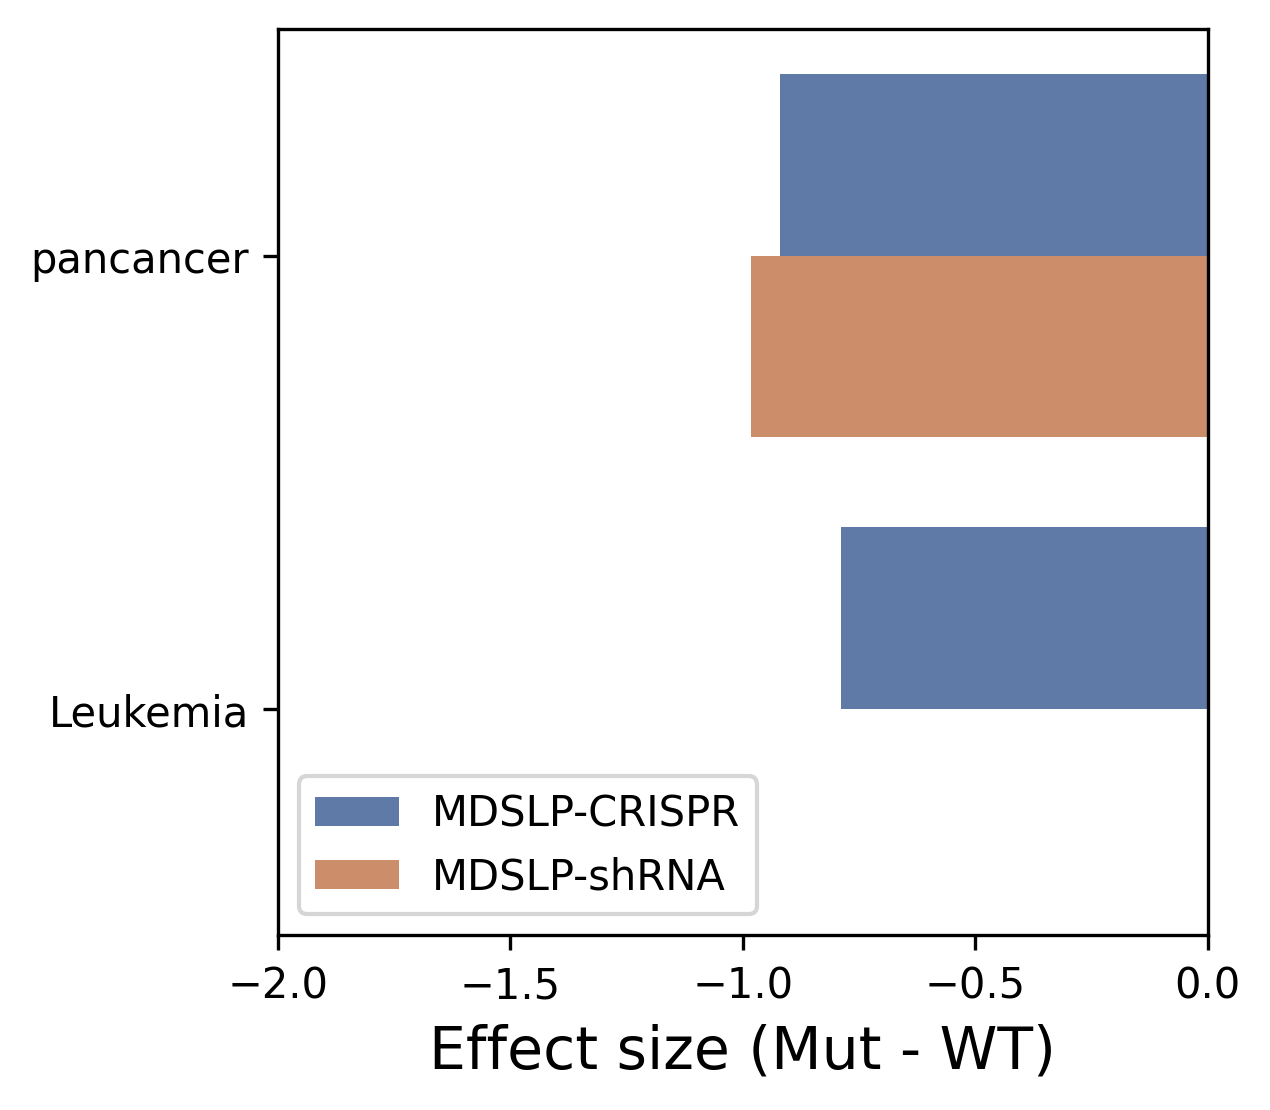

In [24]:
#Plot the results of the gene pairs in different tumor types. Effect size is shown in the figure below.

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = [4,4], dpi = 300)

clrs = []
for x in range(0,int(result.shape[0]/2)):
    clrs.append('#5477b4')
    clrs.append('#dc895a')

ax = sns.barplot(x="ES", y="Tumor_type", hue="source",data=result,
                 orient = 'h', 
                 palette = clrs)

plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
ax.set_xlabel('Effect size (Mut - WT)', fontsize=14)
ax.set_ylabel('', fontsize=0)
ax.set(xlim=(-2, 0))
plt.legend(loc='lower left')


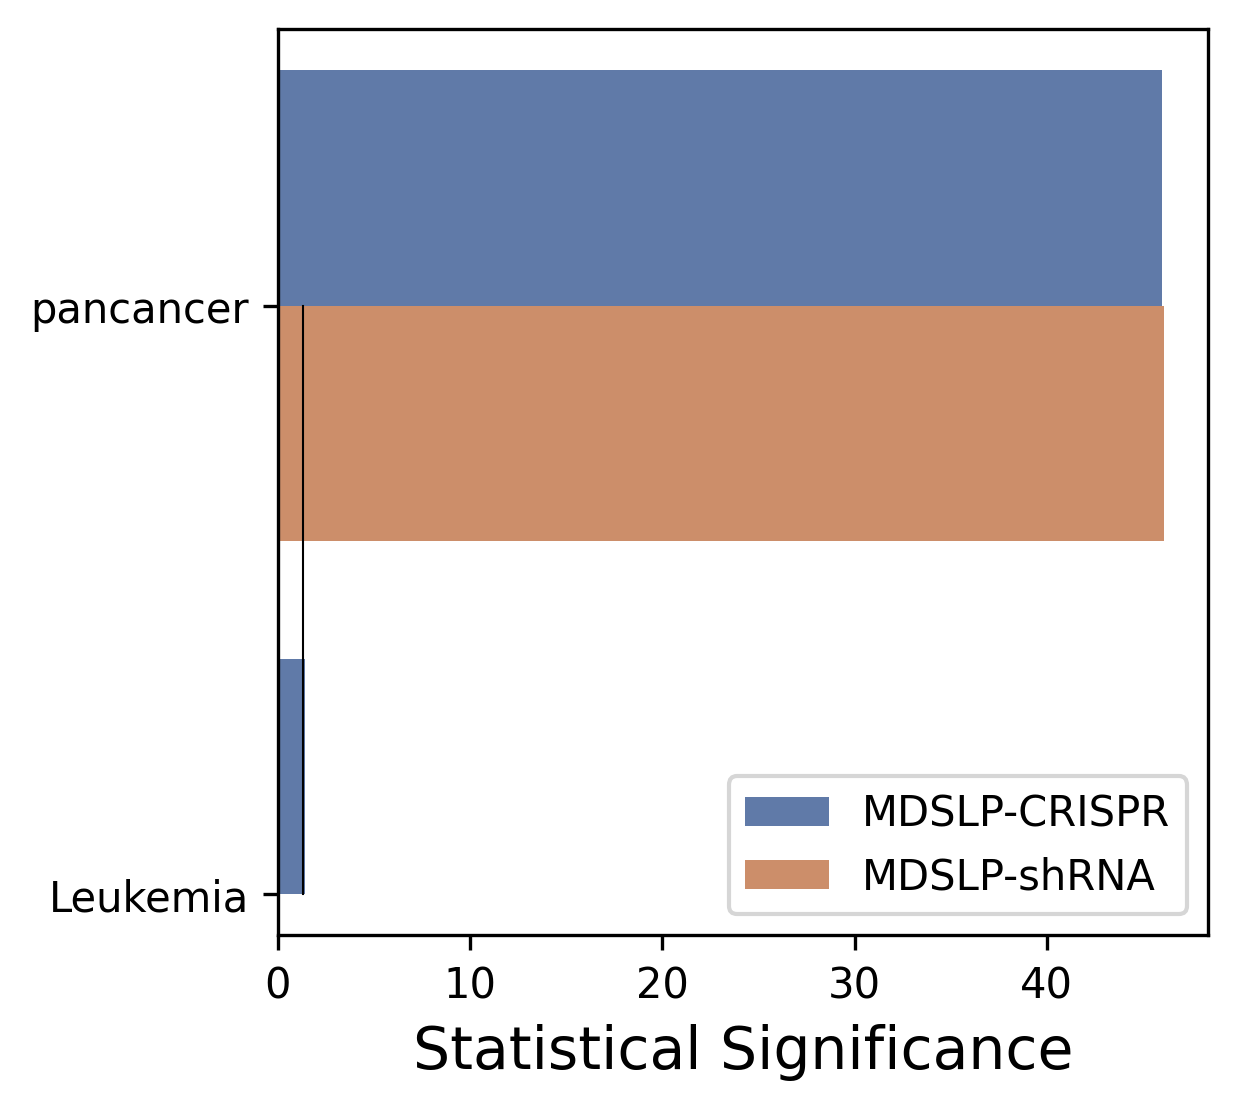

In [25]:
#Plot the results of the gene pairs in different tumor types. negative log-transformed FDR is shown in the figure below.
clrs = []
for x in range(0,int(result.shape[0]/2)):
    clrs.append('#5477b4')
    clrs.append('#dc895a')
    
plt.figure(figsize = [4,4], dpi = 300)
ax1 = sns.barplot(x="-log(FDR)", y="Tumor_type", hue="source",
                  data=result,
                  orient = 'h' ,
                 
                  palette = clrs)
plt.setp(ax1.get_legend().get_texts(), fontsize='8') # for legend text
ax1.set_xlabel('Statistical Significance', fontsize=14) #-1 * log (FDR)
ax1.set_ylabel('', fontsize=0) #ignore the y axis label
plt.legend(loc='lower right')

plt.plot([1.301029996, 1.301029996], [0, int(result.shape[0]/2)], 'k-', lw=0.5) # Plot the significance threshold 1.301029996 = -log(0.05)


In [26]:
result.loc[result['source'] == 'MDSLP-CRISPR'].sort_values(by = ['FDR_all_exp'])

,Gene_mut,Gene_mut_symbol,Gene_kd,Gene_kd_symbol,Mutated_samples,pvalue,ES,FDR_by_gene,FDR_all_exp,Tumor_type,source,-log(FDR)
965,ARID1A,ARID1A,ARID1B,ARID1B,169,6.025520e-25,-0.920789,1.091764e-20,1.091764e-20,pancancer,MDSLP-CRISPR,45.963907
965,ARID1A,ARID1A,ARID1B,ARID1B,10,3.474910e-02,-0.788030,2.451776e-01,2.451776e-01,Leukemia,MDSLP-CRISPR,1.405773


In [ ]:
## End analysis